In [1]:
from fbprophet import Prophet
import cryptocompare
import matplotlib.pyplot as plt
import requests
import pandas as pd
import datetime
import json
from fbprophet.plot import plot_plotly
import seaborn as sns
import holidays
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
import plotly.offline as py
from fbprophet.plot import plot_cross_validation_metric

## Web Scraping

In [2]:
Api_key = "c35caa2391472c618c88a5b9810c28c75b36e6b7a97a0e8dc2d28d447ceec170"

In [3]:
url = "https://min-api.cryptocompare.com/data/v2/histoday?fsym=BTC&tsym=USD&limit=2000"

In [4]:
res = requests.get(url, Api_key).json()
result = res["Data"]["Data"]
result

[{'time': 1442966400,
  'high': 232.2,
  'low': 228.5,
  'open': 230.01,
  'volumefrom': 43602.2,
  'volumeto': 10064288.46,
  'close': 229.89,
  'conversionType': 'direct',
  'conversionSymbol': ''},
 {'time': 1443052800,
  'high': 235.84,
  'low': 229.57,
  'open': 229.89,
  'volumefrom': 72124.09,
  'volumeto': 16797644.6,
  'close': 233.76,
  'conversionType': 'direct',
  'conversionSymbol': ''},
 {'time': 1443139200,
  'high': 237.58,
  'low': 232.7,
  'open': 233.76,
  'volumefrom': 61574.99,
  'volumeto': 14510987.84,
  'close': 235.03,
  'conversionType': 'direct',
  'conversionSymbol': ''},
 {'time': 1443225600,
  'high': 235.71,
  'low': 232.74,
  'open': 235.03,
  'volumefrom': 40288.81,
  'volumeto': 9449846.08,
  'close': 234.3,
  'conversionType': 'direct',
  'conversionSymbol': ''},
 {'time': 1443312000,
  'high': 234.75,
  'low': 231.84,
  'open': 234.3,
  'volumefrom': 36139.39,
  'volumeto': 8429802.53,
  'close': 232.5,
  'conversionType': 'direct',
  'conversionSymb

## Converting data from Json to Pandas' Dataframe

In [5]:
data = pd.json_normalize(result)

In [6]:
data["time"] = [datetime.datetime.fromtimestamp(d) for d in data.time]
data.tail()

time      high       low      open  volumefrom  \
1996 2021-03-11 01:00:00  58142.77  54314.65  55893.31    59202.98   
1997 2021-03-12 01:00:00  58069.58  55089.68  57809.41    54282.31   
1998 2021-03-13 01:00:00  61749.15  56103.32  57256.22    57862.75   
1999 2021-03-14 01:00:00  61674.66  58980.95  61179.79    34886.85   
2000 2021-03-15 01:00:00  59471.74  58732.15  58998.89     1948.59   

          volumeto     close conversionType conversionSymbol  
1996  3.340389e+09  57809.41         direct                   
1997  3.079098e+09  57256.22         direct                   
1998  3.439594e+09  61179.79         direct                   
1999  2.105198e+09  58998.89         direct                   
2000  1.151204e+08  59310.26         direct

In [7]:
df = data[["time", "close"]].copy()

In [8]:
df.head()

time   close
0 2015-09-23 02:00:00  229.89
1 2015-09-24 02:00:00  233.76
2 2015-09-25 02:00:00  235.03
3 2015-09-26 02:00:00  234.30
4 2015-09-27 02:00:00  232.50

### Change Column names to ds and y , the column names required by fbProphet

In [9]:
df[["ds","y"]] = df[["time", "close"]]
df = df.drop(columns=["time","close"])

In [10]:
df.tail()

ds         y
1996 2021-03-11 01:00:00  57809.41
1997 2021-03-12 01:00:00  57256.22
1998 2021-03-13 01:00:00  61179.79
1999 2021-03-14 01:00:00  58998.89
2000 2021-03-15 01:00:00  59310.26

<AxesSubplot:>

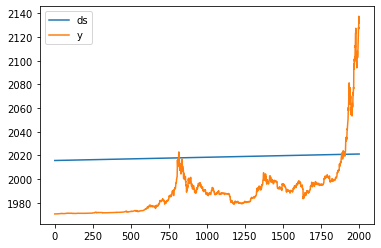

In [11]:
df.plot()

## Split into Text and Train

In [12]:
train_split = 0.9
num_train = int(train_split * df.shape[0])
train = df.iloc[:num_train]
test = df.iloc[num_train:]
train.shape, test.shape

((1800, 2), (201, 2))

In [13]:
train.ds.dtype

dtype('<M8[ns]')

## Model Hyperparameter tuning and prediction

In [14]:
model = Prophet(seasonality_mode="multiplicative", interval_width=0.95, yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True,)
model.fit(train)

In [15]:
horizon =300
future = model.make_future_dataframe(periods=horizon, freq="D")
forecast = model.predict(future)
forecast.tail()

ds       trend    yhat_lower    yhat_upper  trend_lower  \
2095 2021-06-18 02:00:00  788.036922 -34302.531811  56713.698849 -2468.980198   
2096 2021-06-19 02:00:00  788.323851 -34380.920649  59447.942207 -2483.556843   
2097 2021-06-20 02:00:00  788.610780 -34895.264847  57378.152098 -2498.133487   
2098 2021-06-21 02:00:00  788.897709 -36569.807233  58681.083855 -2512.710132   
2099 2021-06-22 02:00:00  789.184637 -34794.634923  58735.066630 -2527.286777   

      trend_upper      daily  daily_lower  daily_upper  multiplicative_terms  \
2095  4163.304330  12.252035    12.252035    12.252035             12.668337   
2096  4193.841581  12.252035    12.252035    12.252035             12.739005   
2097  4231.630912  12.252035    12.252035    12.252035             12.704457   
2098  4269.420243  12.252035    12.252035    12.252035             12.811539   
2099  4307.171334  12.252035    12.252035    12.252035             12.772789   

      ...    weekly  weekly_lower  weekly_upper    yearly  yearly_lower  \
2095  ...  0.004587      0.004587      0.004587  0.411715      0.411715   
2096  ...  0.037650      0.037650      0.037650  0.449320      0.449320   
2097  ... -0.030706     -0.030706     -0.030706  0.483128      0.483128   
2098  ...  0.046993      0.046993      0.046993  0.512512      0.512512   
2099  ... -0.016236     -0.016236     -0.016236  0.536990      0.536990   

      yearly_upper  additive_terms  additive_terms_lower  \
2095      0.411715             0.0                   0.0   
2096      0.449320             0.0                   0.0   
2097      0.483128             0.0                   0.0   
2098      0.512512             0.0                   0.0   
2099      0.536990             0.0                   0.0   

      additive_terms_upper          yhat  
2095                   0.0  10771.154429  
2096                   0.0  10830.785107  
2097                   0.0  10807.482851  
2098                   0.0  10895.891619  
2099                   0.0  10869.273598  

[5 rows x 22 columns]

### Prediction plotting

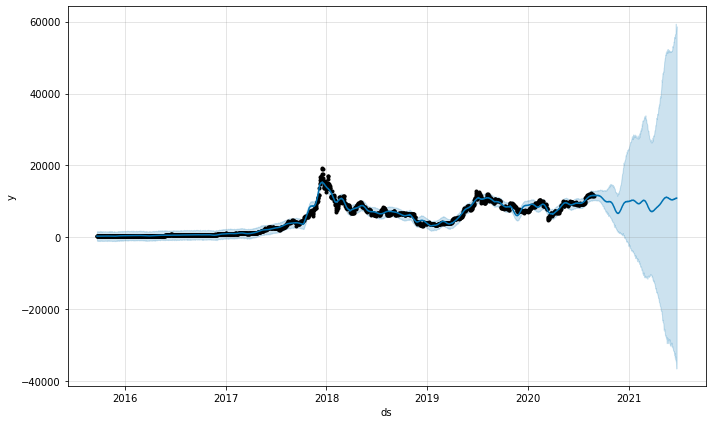

In [16]:
fig = model.plot(forecast)

### Plotting Train , test and predictions

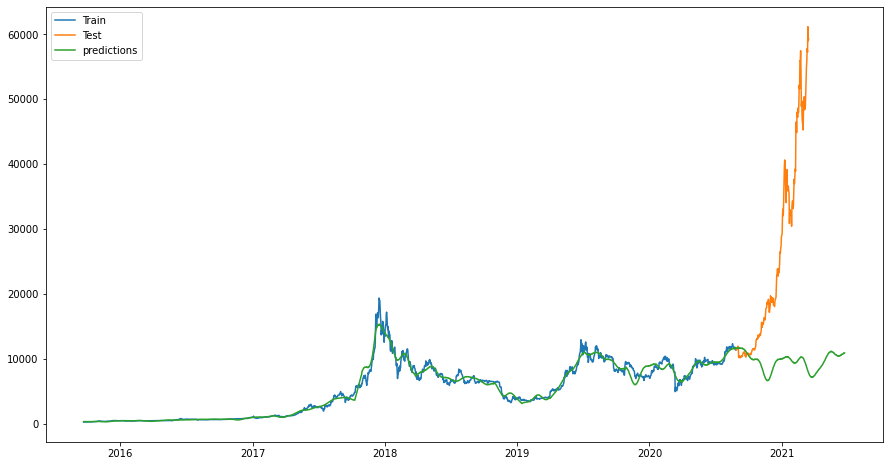

In [17]:
plt.figure(figsize=(15, 8))
plt.plot(train['ds'], train['y'], label="Train")
plt.plot(test['ds'], test['y'], label="Test")
plt.plot(forecast['ds'], forecast['yhat'], label="predictions")
plt.legend(loc="best")
plt.show()


We can see that our prediction is not generalizing, It seems to have learnt the test data so well that it can not generalize. This is called Overfitting.

/home/sayo/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/fbprophet/plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator

/home/sayo/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/fbprophet/plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator

/home/sayo/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/fbprophet/plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator



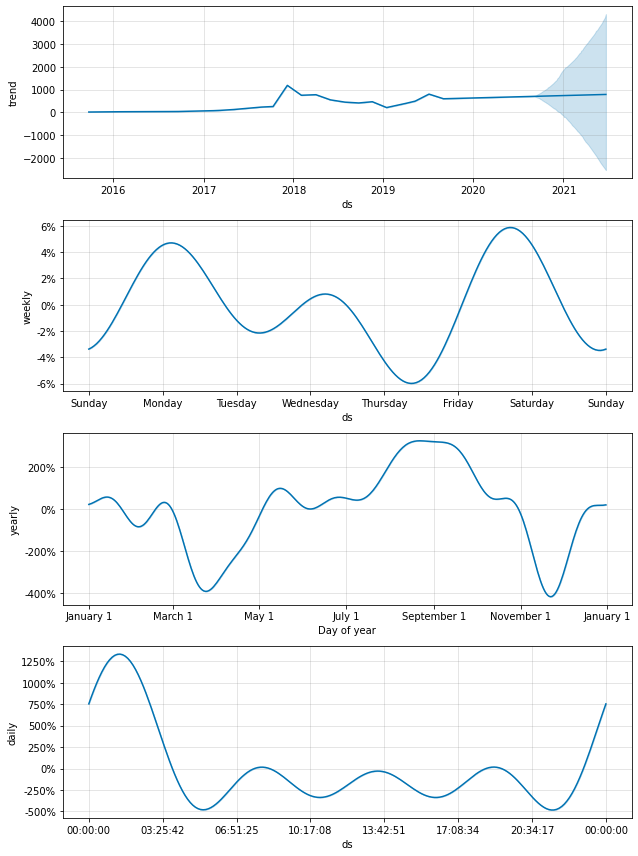

In [18]:
model.plot_components(forecast);

In [19]:
fig_2 = plot_plotly(model, forecast)  # This returns a plotly Figure
py.iplot(fig_2)

### Cross Validation

In [20]:
cv_result = cross_validation( model = model, initial = '600 days', horizon = '300 days')

INFO:fbprophet:Making 6 forecasts with cutoffs between 2017-10-11 02:00:00 and 2019-10-31 02:00:00


  0%|          | 0/6 [00:00<?, ?it/s]

### Performance Metrics

In [21]:
df_performance = performance_metrics(cv_result)
df_performance.head()

horizon           mse         rmse          mae      mape  \
0 30 days 00:00:00  3.197221e+06  1788.077582  1505.765114  0.243204   
1 30 days 23:00:00  3.240852e+06  1800.236617  1522.138098  0.247233   
2 31 days 00:00:00  3.327980e+06  1824.275245  1542.276451  0.248964   
3 31 days 23:00:00  3.365169e+06  1834.439689  1557.322810  0.252713   
4 32 days 00:00:00  3.447828e+06  1856.832902  1576.731210  0.254539   

      mdape  coverage  
0  0.198716  0.255556  
1  0.202404  0.250000  
2  0.203580  0.250000  
3  0.203580  0.244444  
4  0.213883  0.244444

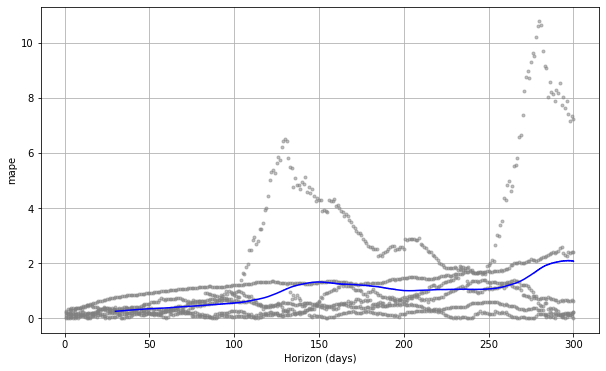

In [23]:
plot_cross_validation_metric(cv_result, metric='mape');

## Tuning parameters and adding more features

In [24]:
data.head()

time    high     low    open  volumefrom     volumeto  \
0 2015-09-23 02:00:00  232.20  228.50  230.01    43602.20  10064288.46   
1 2015-09-24 02:00:00  235.84  229.57  229.89    72124.09  16797644.60   
2 2015-09-25 02:00:00  237.58  232.70  233.76    61574.99  14510987.84   
3 2015-09-26 02:00:00  235.71  232.74  235.03    40288.81   9449846.08   
4 2015-09-27 02:00:00  234.75  231.84  234.30    36139.39   8429802.53   

    close conversionType conversionSymbol  
0  229.89         direct                   
1  233.76         direct                   
2  235.03         direct                   
3  234.30         direct                   
4  232.50         direct

## Multicolinearity

### Feature Engineering

In [25]:
corr = data.corr()
corr

high       low      open  volumefrom  volumeto     close
high        1.000000  0.998334  0.999051    0.009583  0.775174  0.999308
low         0.998334  1.000000  0.998447   -0.020995  0.743124  0.998952
open        0.999051  0.998447  1.000000   -0.000627  0.765637  0.998170
volumefrom  0.009583 -0.020995 -0.000627    1.000000  0.448750 -0.003825
volumeto    0.775174  0.743124  0.765637    0.448750  1.000000  0.761940
close       0.999308  0.998952  0.998170   -0.003825  0.761940  1.000000

<AxesSubplot:>

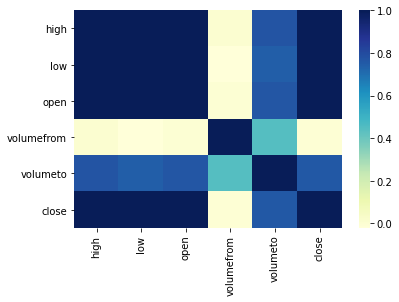

In [26]:
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap= "YlGnBu")

In [27]:
df_new = data[["time","close", "volumeto"]].copy()
#df_new.head()

In [28]:
#check for null values
df_new.isnull().sum()

time        0
close       0
volumeto    0
dtype: int64

In [29]:
df_new.rename(columns = {"time":"ds", "close":"y"}, inplace = True)
df_new.head()

ds       y     volumeto
0 2015-09-23 02:00:00  229.89  10064288.46
1 2015-09-24 02:00:00  233.76  16797644.60
2 2015-09-25 02:00:00  235.03  14510987.84
3 2015-09-26 02:00:00  234.30   9449846.08
4 2015-09-27 02:00:00  232.50   8429802.53

### Add Holidays

In [30]:
holiday = pd.DataFrame([])
for date, name in sorted(holidays.UnitedStates(years=[2015, 2016, 2017, 2018, 2019, 2020, 2021]).items()):
    holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "US-Holidays"}, index=[0]), ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')


In [31]:
holiday.head()

ds      holiday
0 2015-01-01  US-Holidays
1 2015-01-19  US-Holidays
2 2015-02-16  US-Holidays
3 2015-05-25  US-Holidays
4 2015-07-03  US-Holidays

### Split the dataset

In [32]:
train_split = 0.8
num_train = int(train_split * df.shape[0])
train = df_new.iloc[:num_train]
test = df_new.iloc[num_train:]
train.shape, test.shape

((1600, 3), (401, 3))

## Fit the model

In [33]:
m = Prophet(holidays=holiday)


In [34]:
m.add_regressor("volumeto", standardize=False, mode="multiplicative")

In [35]:
m.fit(train)

In [58]:
predictions = m.make_future_dataframe(periods = 400)

In [59]:
predictions.tail()

ds
1995 2021-03-10 01:00:00
1996 2021-03-11 01:00:00
1997 2021-03-12 01:00:00
1998 2021-03-13 01:00:00
1999 2021-03-14 01:00:00

In [60]:
predictions["volumeto"] = df_new["volumeto"]
predictions.head()

ds     volumeto
0 2015-09-23 02:00:00  10064288.46
1 2015-09-24 02:00:00  16797644.60
2 2015-09-25 02:00:00  14510987.84
3 2015-09-26 02:00:00   9449846.08
4 2015-09-27 02:00:00   8429802.53

### Make Predictions

In [61]:
fct = m.predict(predictions)
fct.tail()

ds         trend   yhat_lower    yhat_upper  \
1995 2021-03-10 01:00:00  15204.294901  9666.370086  42098.167120   
1996 2021-03-11 01:00:00  15216.149955  8486.701775  39038.325461   
1997 2021-03-12 01:00:00  15228.005008  8127.871652  37906.673164   
1998 2021-03-13 01:00:00  15239.860062  8703.684022  39811.126782   
1999 2021-03-14 01:00:00  15251.715115  6883.312174  32897.384995   

      trend_lower   trend_upper  US-Holidays  US-Holidays_lower  \
1995  6233.208475  23552.493691          0.0                0.0   
1996  6197.205813  23597.536140          0.0                0.0   
1997  6156.475697  23647.043781          0.0                0.0   
1998  6115.745581  23685.639827          0.0                0.0   
1999  6077.749549  23740.540843          0.0                0.0   

      US-Holidays_upper  additive_terms  ...  volumeto  volumeto_lower  \
1995                0.0    -2029.586228  ...  0.858775        0.858775   
1996                0.0    -2058.891758  ...  0.735880        0.735880   
1997                0.0    -2091.562142  ...  0.678318        0.678318   
1998                0.0    -1898.427398  ...  0.757734        0.757734   
1999                0.0    -1953.210388  ...  0.463770        0.463770   

      volumeto_upper      weekly  weekly_lower  weekly_upper       yearly  \
1995        0.858775 -100.381721   -100.381721   -100.381721  -953.272030   
1996        0.735880  -90.602640    -90.602640    -90.602640  -992.356641   
1997        0.678318  -83.882595    -83.882595    -83.882595 -1031.747071   
1998        0.757734  148.055059    148.055059    148.055059 -1070.549980   
1999        0.463770  130.616199    130.616199    130.616199 -1107.894110   

      yearly_lower  yearly_upper          yhat  
1995   -953.272030   -953.272030  26231.784313  
1996   -992.356641   -992.356641  24354.513878  
1997  -1031.747071  -1031.747071  23465.870840  
1998  -1070.549980  -1070.549980  24889.197327  
1999  -1107.894110  -1107.894110  20371.792215  

[5 rows x 34 columns]

# Visualize Forecast

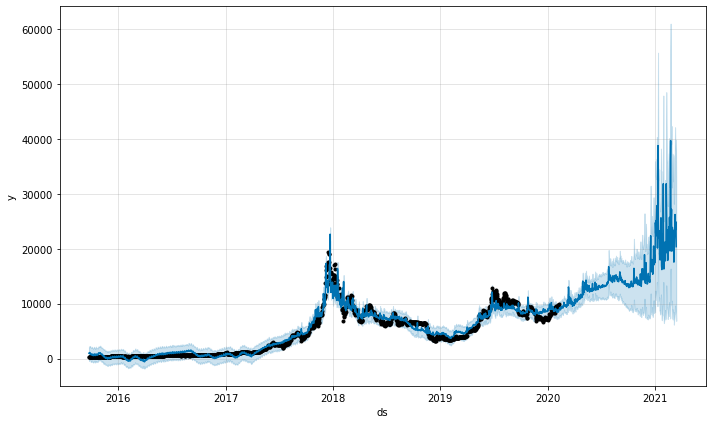

In [62]:
fig2 = m.plot(fct)

/home/sayo/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/fbprophet/plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator



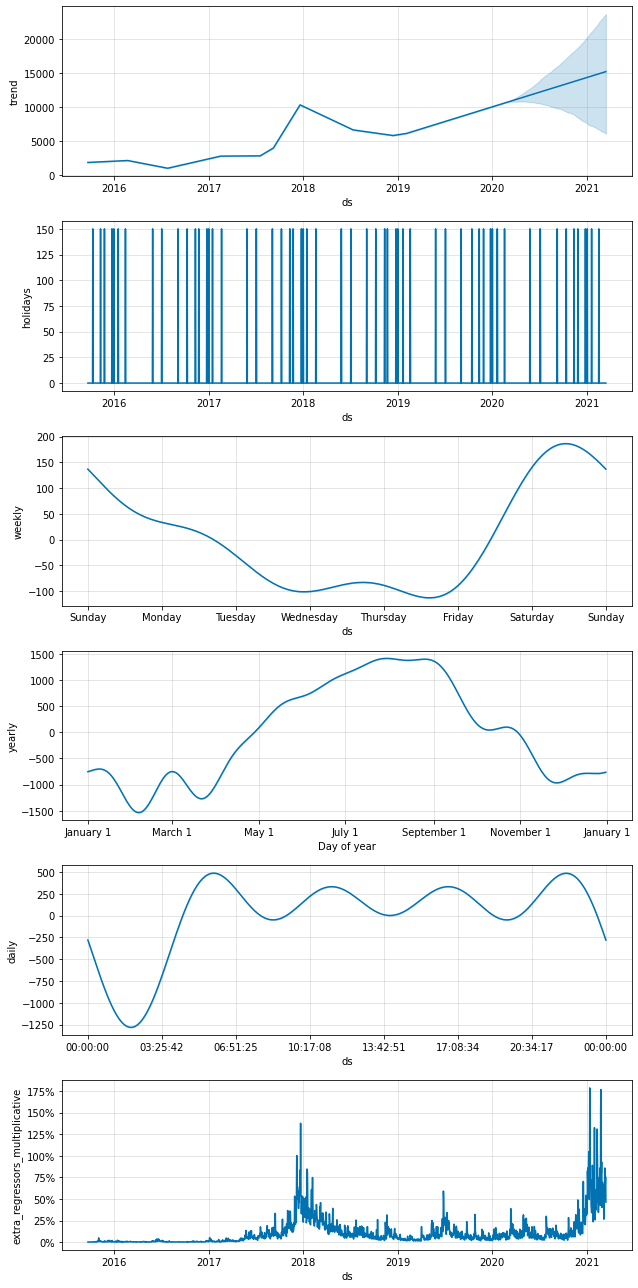

In [63]:
fig3 = m.plot_components(fct)

### Comaparing Train, test and Forecast

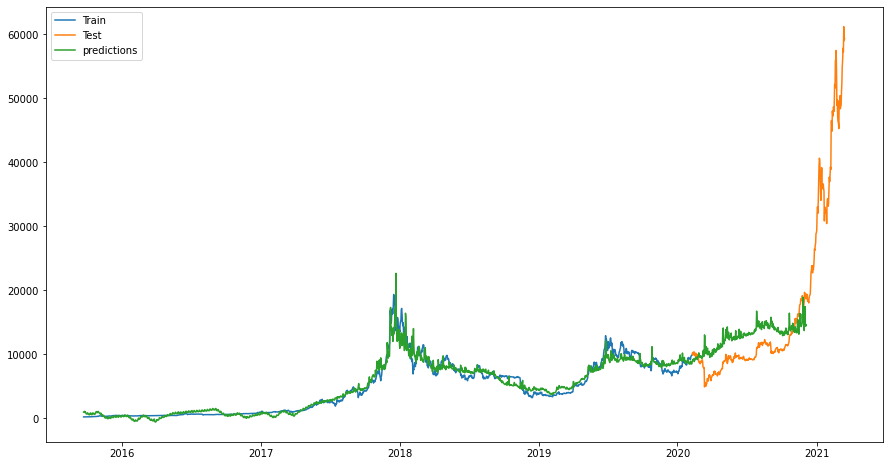

In [42]:
plt.figure(figsize=(15, 8))
plt.plot(train['ds'], train['y'], label="Train")
plt.plot(test['ds'], test['y'], label="Test")
plt.plot(fct['ds'], fct['yhat'], label="predictions")
plt.legend(loc="best")
plt.show()


In [64]:
import plotly.offline as py

fig_2 = plot_plotly(m, fct)  # This returns a plotly Figure
py.iplot(fig_2)

## Cross Validation

In [65]:
cv_results = cross_validation( model = m, initial = '600 days', horizon = '300 days')

INFO:fbprophet:Making 5 forecasts with cutoffs between 2017-08-22 01:00:00 and 2019-04-14 01:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

### Performance Metrics

In [66]:
df_performance = performance_metrics(cv_results)
df_performance.head()

horizon           mse         rmse          mae      mape  \
0 30 days 00:00:00  8.301885e+06  2881.299186  2067.907901  0.343330   
1 30 days 01:00:00  8.332632e+06  2886.629881  2073.909655  0.343389   
2 31 days 00:00:00  8.524808e+06  2919.727435  2117.798908  0.352678   
3 31 days 01:00:00  8.611212e+06  2934.486716  2133.590104  0.353648   
4 32 days 00:00:00  8.800396e+06  2966.546208  2169.309825  0.360762   

      mdape  coverage  
0  0.291167  0.253333  
1  0.291167  0.253333  
2  0.309247  0.246667  
3  0.309247  0.246667  
4  0.315113  0.240000

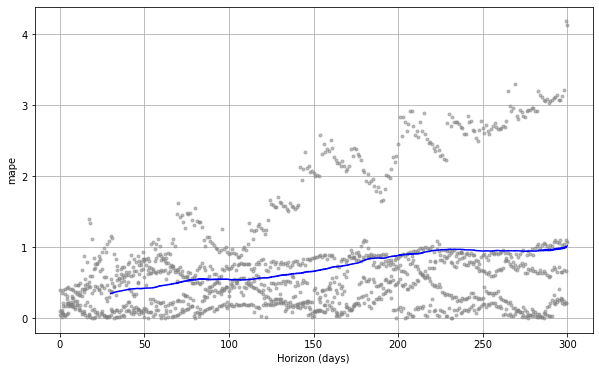

In [67]:
# Plot results below
from fbprophet.plot import plot_cross_validation_metric
plot_cross_validation_metric(cv_results, metric='mape');

### Conclusion

It seems adding holiday and another feature helped to increase the accuracy and performance of our model but we could still get better result by trying other models